VIS_NIR tutorial

For dual VIS/NIR workflows, a visible image is used to identify an image mask for the plant material. The get nir function is used to get the NIR image that matches the VIS image (must be in same folder, with similar naming scheme), then functions are used to size and place the VIS image mask over the NIR image. This allows two workflows to be done at once and also allows plant material to be identified in low-quality images. We do not recommend this approach if there is a lot of plant movement between capture of NIR and VIS images.

To run a VIS/NIR workflow over a single VIS image there are two required inputs:

1. Image: Images can be processed regardless of what type of VIS camera was used (high-throughput platform, digital camera, cell phone camera).
Image processing will work with adjustments if images are well lit and free of background that is similar in color to plant material.
2. Output directory: If debug mode is set to 'print' output images from each intermediate step are produced.

In [1]:
#Import the needed packages needed to run verything.
%matplotlib widget
from plantcv import plantcv as pcv
from plantcv.parallel import WorkflowInputs
import matplotlib
import cv2
import numpy as np
import argparse 
from  matplotlib import pyplot as plt
import os
from skimage import exposure, img_as_float


In [5]:
#Import a sample image and define it to be used in the notebook
args = WorkflowInputs(
    images=["./sample_images/VIS_SV_0_z1_h1_g0_e77_v500_84572_0.png",
            "./sample_images/NIR_SV_0_z1_h1_g0_e21500_v500_84575_0.png"],
    names="vis,nir",
    result="data_output.csv",
    outdir="img_output",
    writeimg=False,
    debug="plot"
)


In [6]:
# Set debug to the global parameter 
pcv.params.debug = args.debug

# Change the display settings
pcv.params.dpi = 100
pcv.params.text_size = 20
pcv.params.text_thickness = 20
pcv.params.debug_outdir = args.outdir

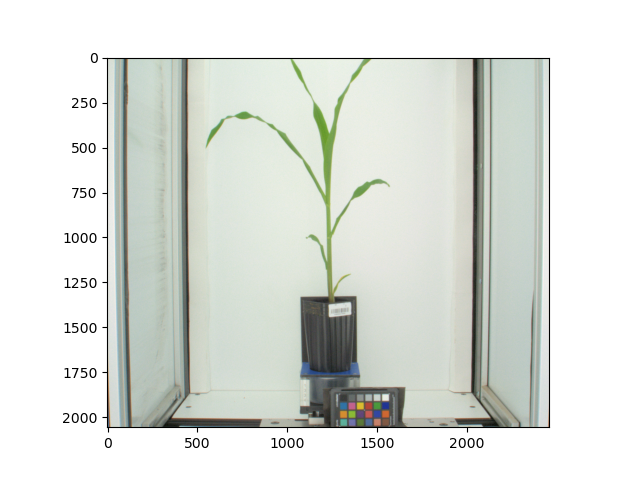

In [7]:
# Read VIS image 

# Filename - Image file to be read in  
img, path, filename = pcv.readimage(filename=args.vis)

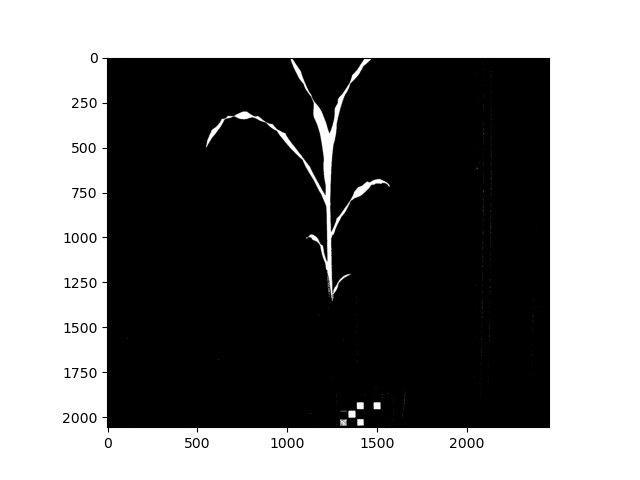

In [8]:
# Threshold 1
thresh1 = pcv.threshold.dual_channels(rgb_img = img, x_channel = "a", y_channel = "b", points = [(100,130),(130,175)], above=True)

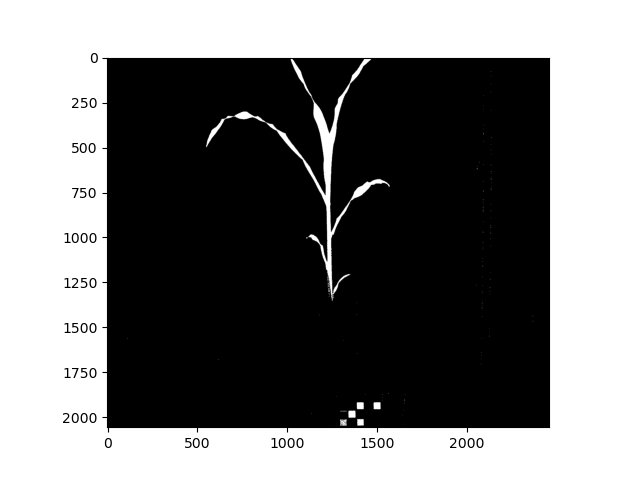

In [9]:
# Remove Noise
thresh1_fill = pcv.fill(bin_img=thresh1, size=3)

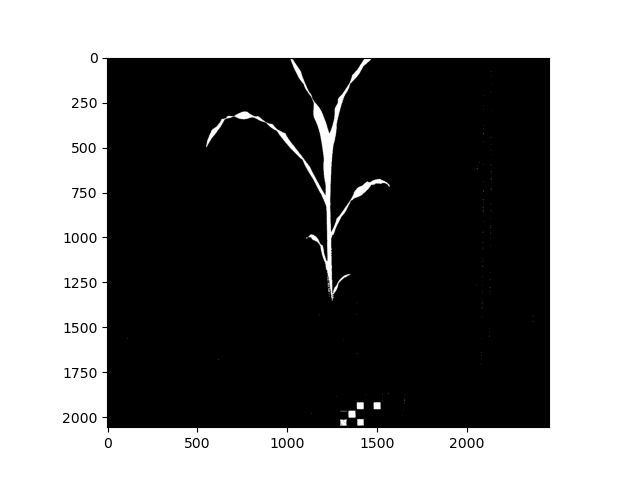

In [10]:
# Fill in small objects 
thresh1_filled_holes = pcv.closing(gray_img=thresh1_fill)

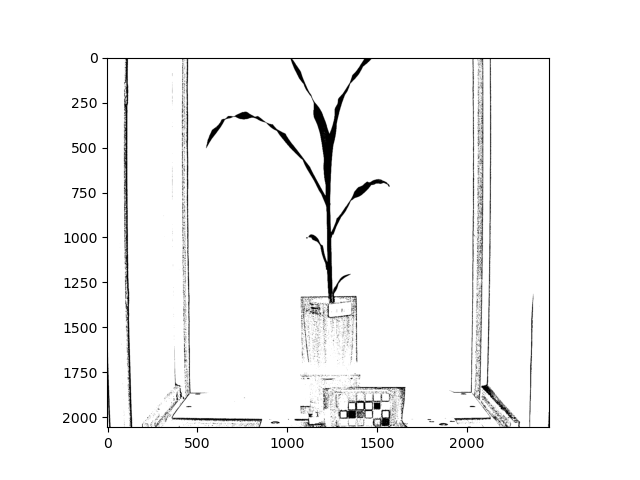

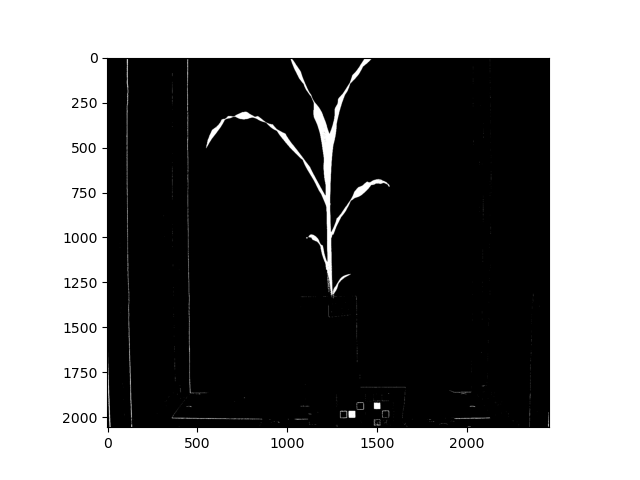

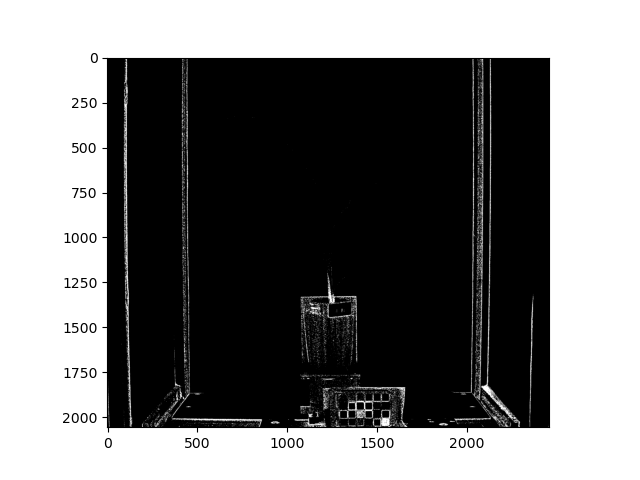

In [11]:
# Threshold using Naive Bayes

thresh2 = pcv.naive_bayes_classifier(rgb_img=img, 
                                  pdf_file="./naive_bayes/maize_naive_bayes_pdfs_new.txt")


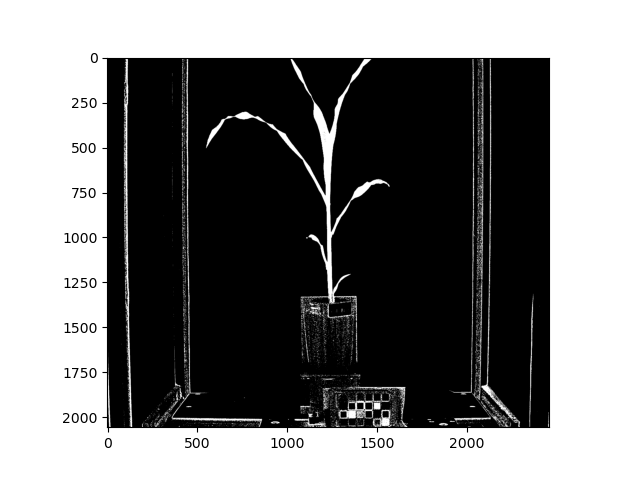

In [12]:
# Threshold 2
thresh2_plant = pcv.logical_or(thresh2['greenplant'], thresh2['purpleplant'])

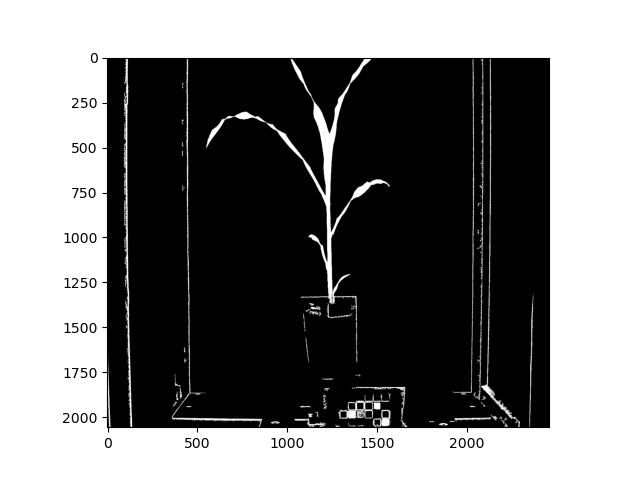

In [13]:
# Fill the naive bayes threshold
thresh2_fill = pcv.fill(bin_img=thresh2_plant, size=100)

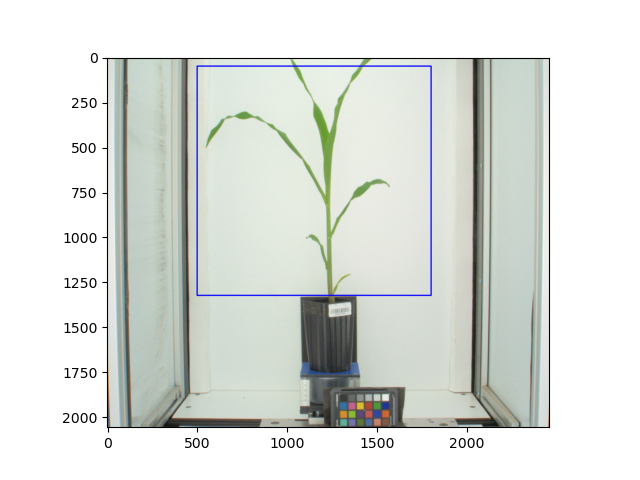

In [14]:
# Define ROI - utilizes Objects
roi = pcv.roi.rectangle(img=img, x=500, y=50, h=1275, w=1300)

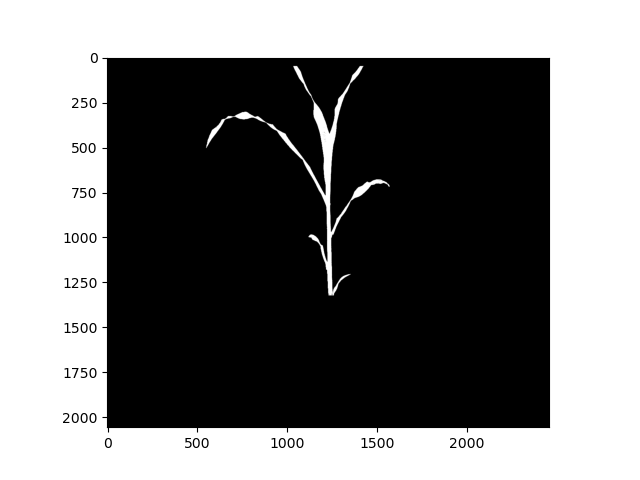

In [15]:
# Filter binary image to make a clean mask
mask = pcv.roi.filter(mask=thresh2_fill, roi=roi,
roi_type="cutto")

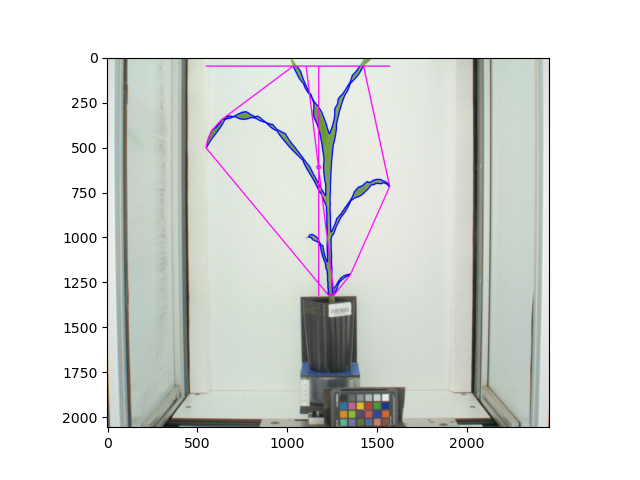

In [16]:
############### VIS (RGB) Analysis ################ 
shape_img = pcv.analyze.size(img=img,labeled_mask=mask, n_labels=1)

In [17]:
# Determine color properties: Histograms, Color Slices and Pseudocolored Images, output color analyzed images (optional)

# Inputs:
#   rgb_img - RGB image data
#   mask - Binary mask of selected contours 
#   colorspaces - 'all' (default), 'rgb', 'lab', or 'hsv'
#   This is the data to be printed to the SVG histogram file  
#   label - Optional label parameter, modifies the variable name of observations recorded. (default `label="default"`)

color_histogram = pcv.analyze.color(rgb_img=img, labeled_mask=mask, colorspaces='all', label="default")


alt.FacetChart(...)

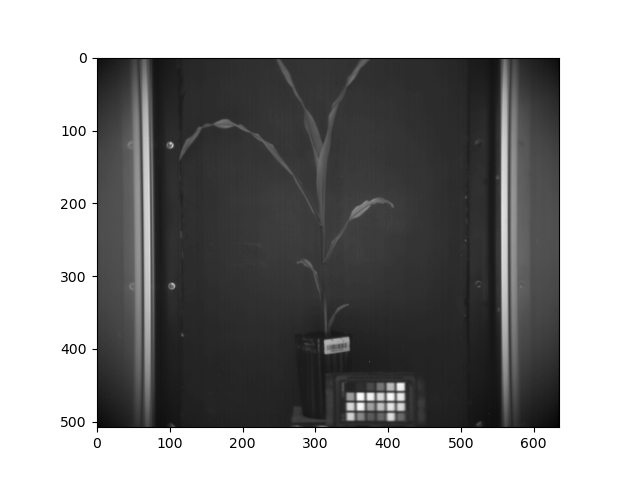

In [18]:
nir, path1, filename1 = pcv.readimage(filename=args.nir, mode='native')

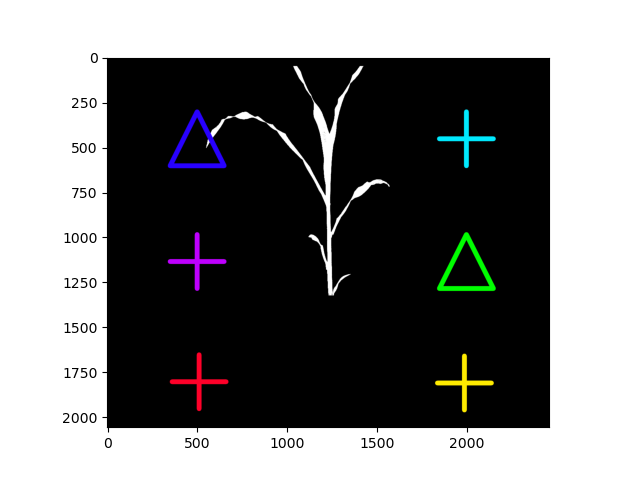

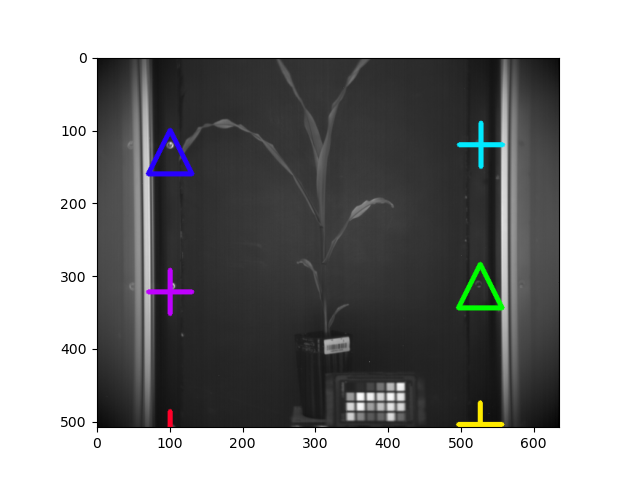

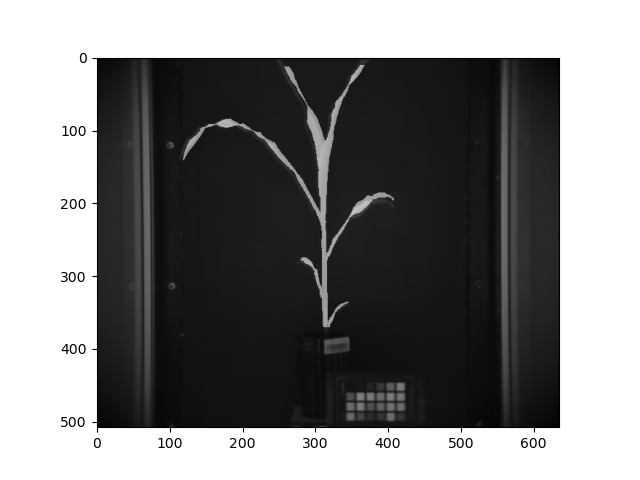

In [19]:
img_warped, mat = pcv.transform.warp(img=mask, refimg=nir,
                                     pts = [(500, 454), (1995, 454), (1995, 1136), (1984, 1811), (511, 1804), 
                                            (500, 1136)],
                                     refpts = [(100, 130), (527, 120), (526, 314), (526, 504), (100, 516), 
                                               (100, 322)],
                                     method='lmeds')

<IPython.core.display.Javascript object>


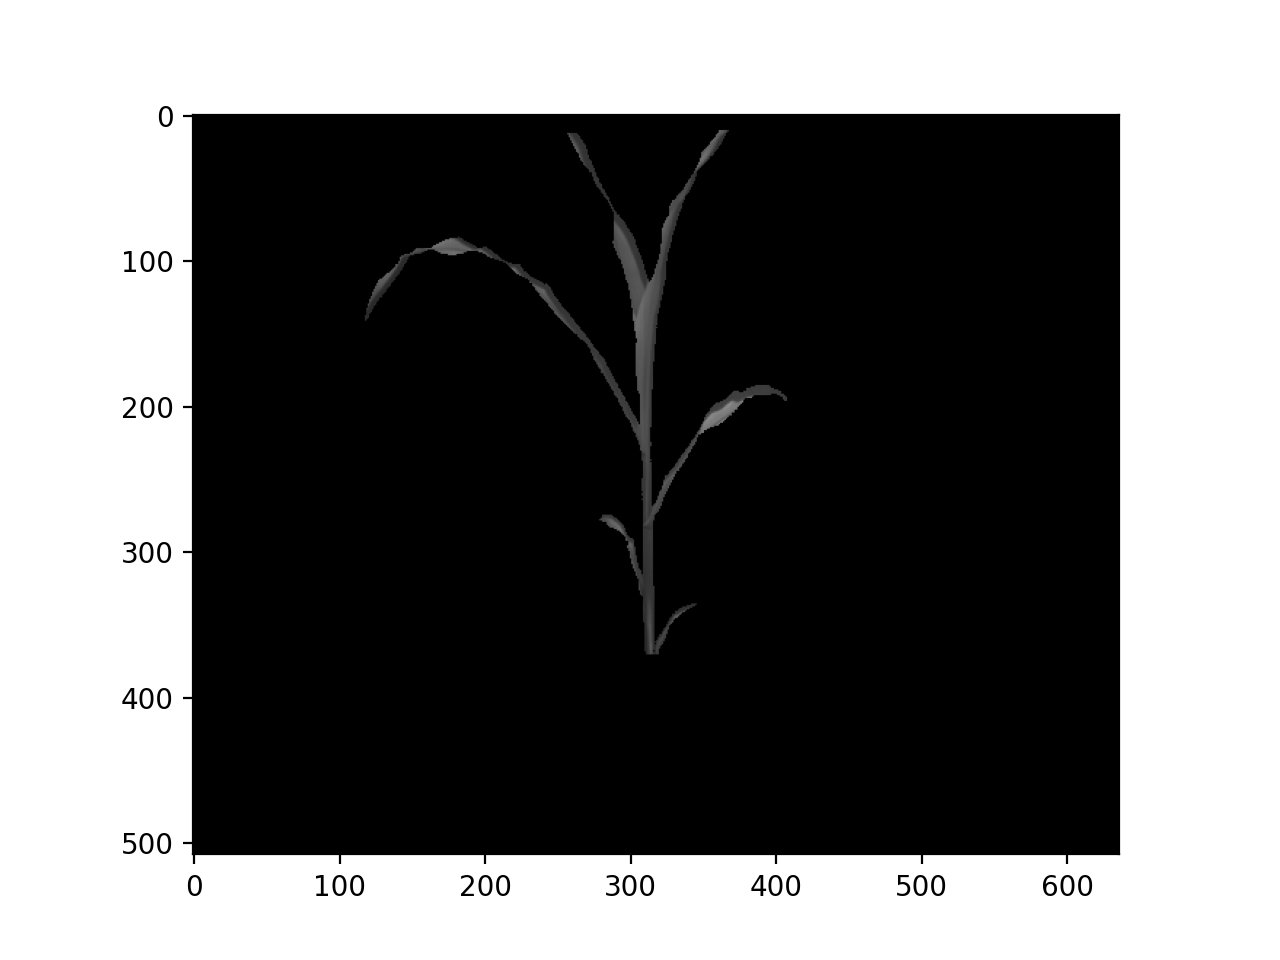

<IPython.core.display.Javascript object>


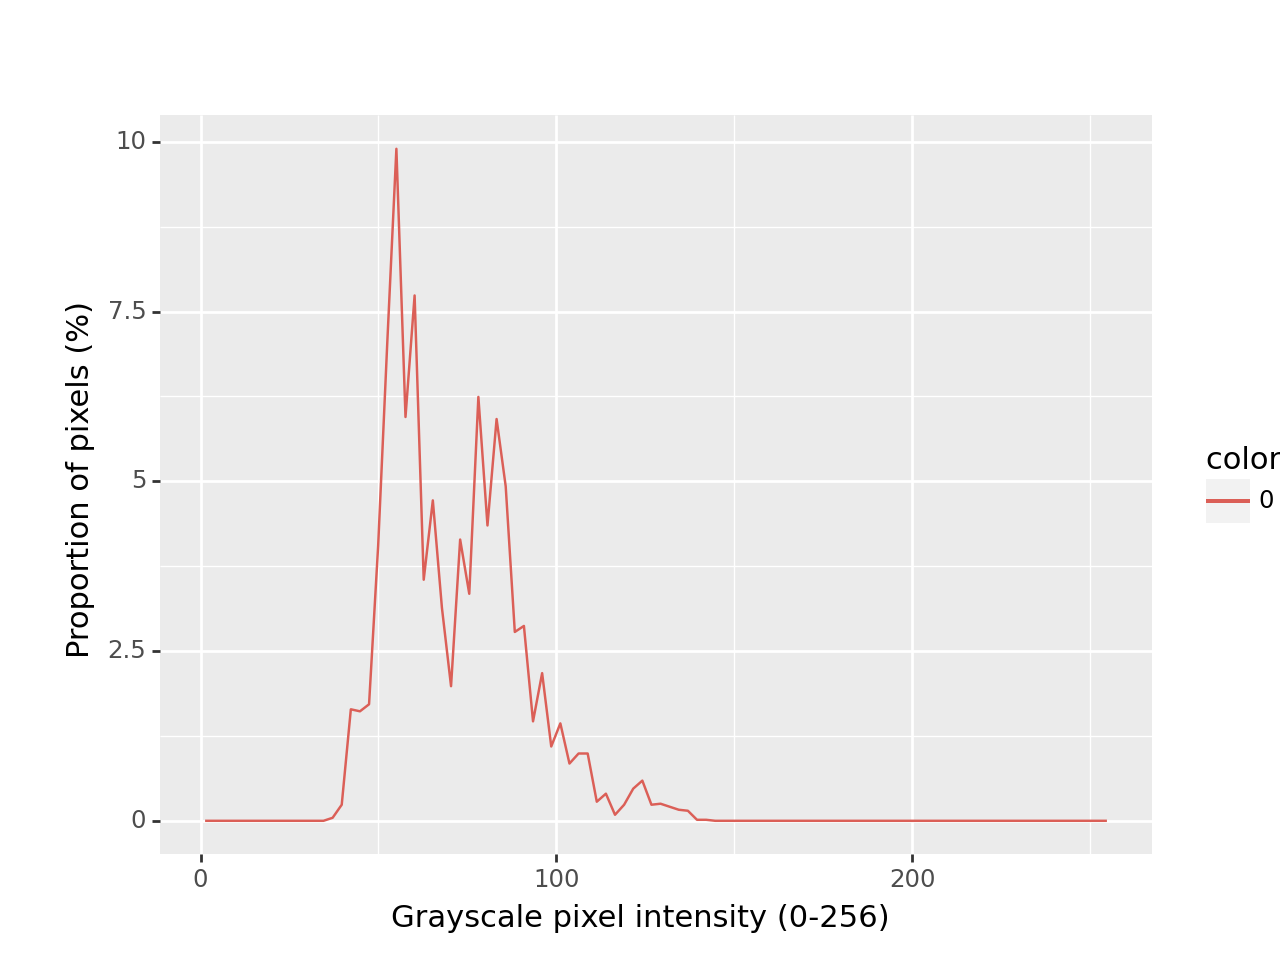

In [27]:
nir_hist = pcv.analyze.grayscale(gray_img=nir, labeled_mask=img_warped, 
                                     bins=100, label="NIR")

# Print out the nir histogram to save it.  
#pcv.print_image(img=nir_hist, filename=os.path.join(args.outdir, filename + "_NIR.jpg"))
#pcv.print_image(img=nir_combinedmask, filename=os.path.join(args.outdir, filename + "_NIRmask.jpg"))

/bioinfo/envs/plantcv/lib/python3.10/site-packages/plotnine/ggplot.py:365: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


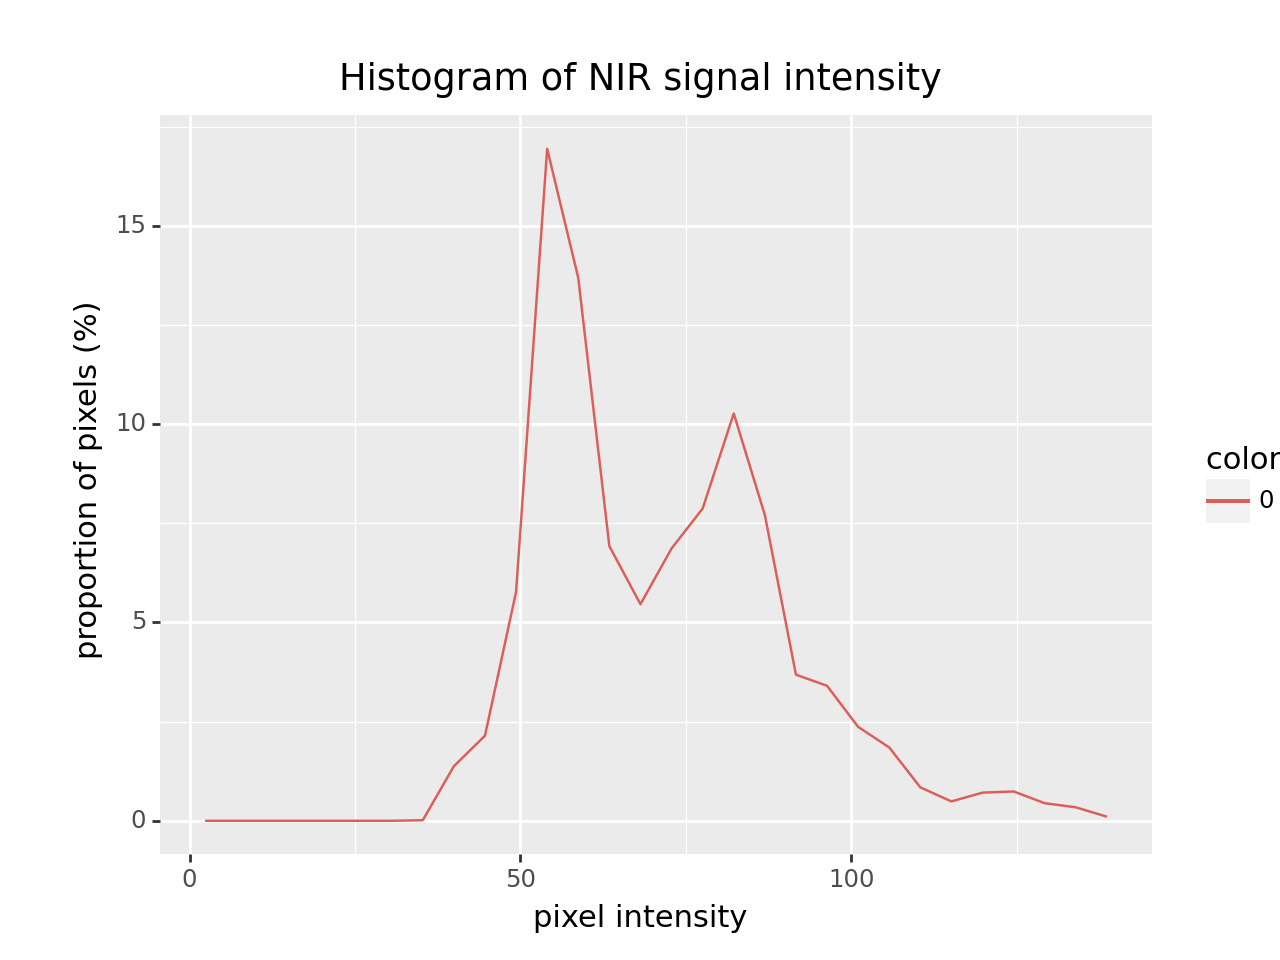

In [28]:
nir_hist = pcv.visualize.histogram(img=nir, mask=img_warped, lower_bound=0, upper_bound=None, bins=30, title="Histogram of NIR signal intensity")

In [5]:
# The save results function will take the measurements stored when running any PlantCV analysis functions, format, 
# and print an output text file for data analysis.
pcv.outputs.save_results(filename=args.result)